In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import os, sys
# Configure plotting
plt.rcParams["figure.figsize"] = (6,4)
# Custom libraries and routines
!rm -rf ~/personal_gkyl_scripts/pygkyl/pygkyl.egg-info
!rm -rf ~/personal_gkyl_scripts/pygkyl/build
!{sys.executable} -m pip install ~/personal_gkyl_scripts/pygkyl > ~/personal_gkyl_scripts/pygkyl/install.log
import pygkyl
# Setup path to data
home_dir = os.path.expanduser("~")
repo_dir = home_dir+'/personal_gkyl_scripts/'
simdir = repo_dir+'sim_data_dir_example/3x2v_example/gk_tcv_posD_iwl_3x2v_electron_heating/'
fileprefix = 'gk_tcv_posD_iwl_3x2v_D02'
# Create simulation object
simulation = pygkyl.Simulation(dimensionality='3x2v')
simulation.set_phys_param(
    eps0 = 8.854e-12,       # Vacuum permittivity [F/m]
    eV = 1.602e-19,         # Elementary charge [C]
    mp = 1.673e-27,         # Proton mass [kg]
    me = 9.109e-31,         # Electron mass [kg]
)
def qprofile(R):
    a = [497.3420166252413, -1408.736172826569, 1331.4134861681464, -419.00692601227627]
    return a[0]*R**3 + a[1]*R**2 + a[2]*R + a[3]
simulation.set_geom_param(
    B_axis = 1.4,           # Magnetic field at magnetic axis [T]
    R_axis      = 0.8727315068,         # Magnetic axis major radius
    Z_axis      = 0.1414361745,         # Magnetic axis height
    R_LCFSmid   = 1.0968432365089495,   # Major radius of LCFS at the midplane
    a_shift     = 0.25,                 # Parameter in Shafranov shift
    kappa       = 1.5,                  # Elongation factor
    delta       = 0.3,                  # Triangularity factor
    qprofile    = qprofile,             # Safety factor
    x_LCFS      = 0.04,                 # position of the LCFS (= core domain width)
    x_out       = 0.08                  # SOL domain width
)
# Define the species
ion = pygkyl.Species(name='ion',
              m=2.01410177811*simulation.phys_param.mp, # Ion mass
              q=simulation.phys_param.eV,               # Ion charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
elc = pygkyl.Species(name='elc',
              m=simulation.phys_param.me, 
              q=-simulation.phys_param.eV, # Electron charge [C]
              T0=100*simulation.phys_param.eV, 
              n0=2.0e19)
# Add them to the simulation (we need to know this before setting up the data parameters)
simulation.add_species(ion)
simulation.add_species(elc)
# This call will set up the data structure of the simulation and set up a large dictionary 
# conaining the receipes of many post processing quantities, see simulation.data_param.info()
simulation.set_data_param( simdir = simdir, fileprefix = fileprefix, species = simulation.species)
# This is the first call that will load data. 
simulation.geom_param.load_metric(simulation.data_param.fileprefix)

-- Source Informations --
Total input particle: 1.32046e+21 part/s
Grad-B drift loss: 1.29371 %
(input particle after grad-B drift: 1.30337e+21 part/s)
Total input power: 6.34612 kW
Grad-B drift loss: 1.29371 %
(input power after grad-B drift: 6.26402 kW)


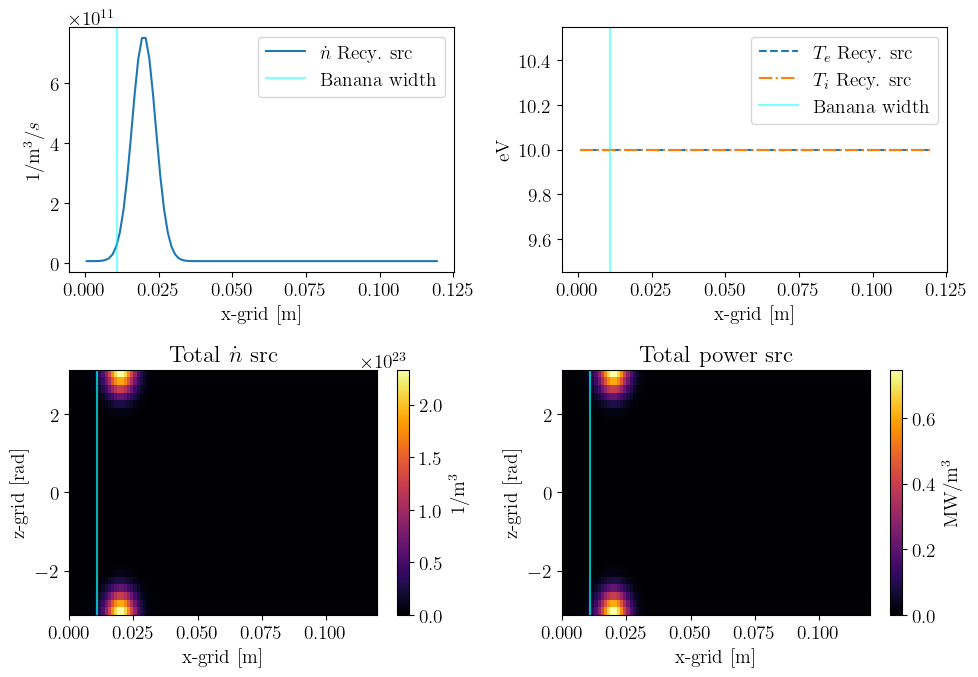

In [7]:
# --- RECYCLIRECYG SOURCE ---
n_srcRECY = 2.4e23
x_srcRECY = 0.5 * simulation.geom_param.x_LCFS
Te_srcRECY = 10 * simulation.phys_param.eV
Ti_srcRECY = 10 * simulation.phys_param.eV
sigmax_srcRECY = 0.1*(simulation.geom_param.x_LCFS)
sigmaz_srcRECY = 0.07 * simulation.geom_param.Lz
floor_src=1e-2
def density_src_RECY(x,y,z):
    # create a z envelope centered at z = -pi with a width of pi/4
    z_envelope = np.exp(-((z + np.pi) ** 2) / (2.0 * sigmaz_srcRECY ** 2)) + np.exp(-((z - np.pi) ** 2) / (2.0 * sigmaz_srcRECY ** 2))
    return z_envelope*n_srcRECY * (np.exp(-((x - x_srcRECY) ** 2) / (2.0 * sigmax_srcRECY ** 2)) + floor_src)
def temp_src_elc_RECY(x, y = None, z = None):
    return np.ones_like(x) * Te_srcRECY  
def temp_src_ion_RECY( x, y = None, z = None):
    return np.ones_like(x) * Te_srcRECY  

RECYsource = pygkyl.Source(n_src=n_srcRECY,x_src=x_srcRECY,Te_src=Te_srcRECY,Ti_src=Ti_srcRECY,
                   sigma_src=sigmax_srcRECY,floor_src=floor_src,
                   density_src_profile=density_src_RECY,
                   temp_src_profile_elc=temp_src_elc_RECY,
                   temp_src_profile_ion=temp_src_ion_RECY)
simulation.add_source('Recy. src',RECYsource)
pygkyl.plot_utils.plot_sources_info(simulation,x_const=None,z_const=0.0)


In [8]:
# --- OMP SOURCE ---
# n_srcOMP=2.4e23 ## original
n_srcOMP=1.5e24 ## (adapted to compensate for the gradB loss)
Te_srcOMP=3 * simulation.species['elc'].T0
Ti_srcOMP=3 * simulation.species['ion'].T0
sigma_srcOMP=0.03 * simulation.geom_param.Lx
x_srcOMP=0#2*sigma_srcOMP
floor_src=1e-2
def density_src_OMP(x,y,z):
    return n_srcOMP * (np.exp(-((x - x_srcOMP) ** 2) / (2.0 * sigma_srcOMP ** 2)) + floor_src)
def temp_src_elc_OMP(x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Te_srcOMP; fout[~mask] = Te_srcOMP * 3.0 / 8.0
    return fout  
def temp_src_ion_OMP( x, y = None, z = None):
    mask = x < (x_srcOMP + 3 * sigma_srcOMP)
    fout = np.empty_like(x)
    fout[mask] = Ti_srcOMP; fout[~mask] = Ti_srcOMP * 3.0 / 8.0
    return fout   
OMPsource = pygkyl.Source(n_src=n_srcOMP,x_src=x_srcOMP,Te_src=Te_srcOMP,Ti_src=Ti_srcOMP,
                   sigma_src=sigma_srcOMP,floor_src=floor_src,
                   density_src_profile=density_src_OMP,
                   temp_src_profile_elc=temp_src_elc_OMP,
                   temp_src_profile_ion=temp_src_ion_OMP)
simulation.add_source('OMPsource',OMPsource)

-- Source Informations --
Total input particle: 3.2122e+22 part/s
Grad-B drift loss: 70.2757 %
(input particle after grad-B drift: 9.54802e+21 part/s)
Total input power: 3718.93 kW
Grad-B drift loss: 87.4534 %
(input power after grad-B drift: 466.6 kW)


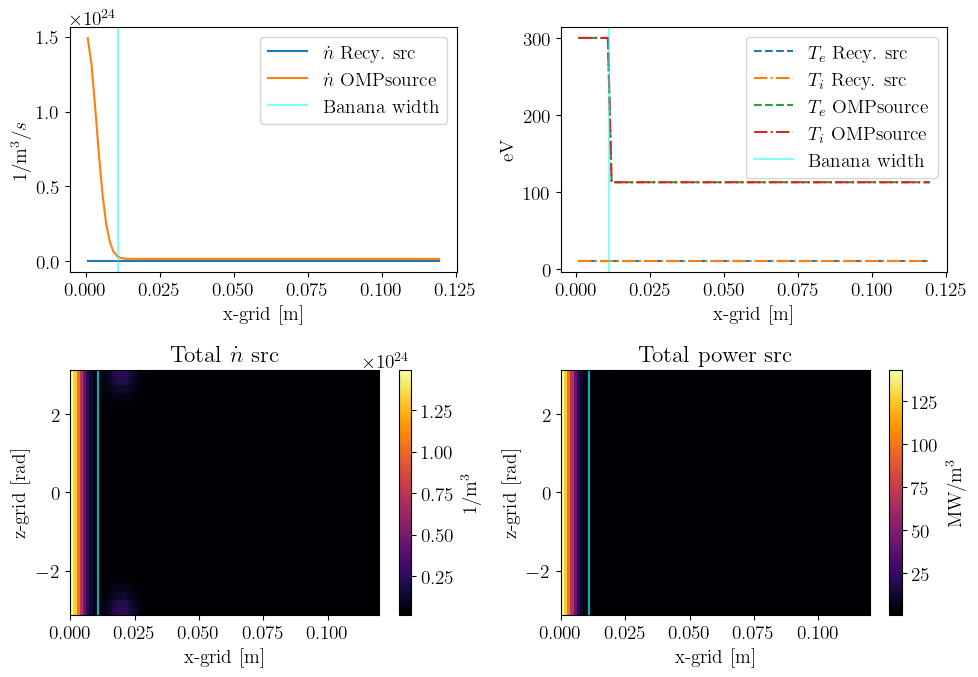

In [9]:
# --- PLOT SOURCES ---
pygkyl.plot_utils.plot_sources_info(simulation,x_const=None,z_const=0.0)
x = simulation.geom_param.grids[0]
total_density_src = RECYsource.density_profile(x,0,0) + OMPsource.density_profile(x,0,0)
total_temp_src_elc = RECYsource.temp_profile_elc(x,0,0) + OMPsource.temp_profile_elc(x,0,0)
total_temp_src_ion = RECYsource.temp_profile_ion(x,0,0) + OMPsource.temp_profile_ion(x,0,0)

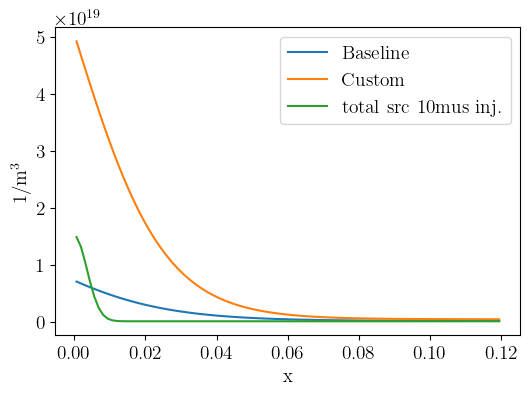

In [ ]:
# baseline density profile
n0_bl = 2e19
T0_bl = 100*simulation.phys_param.eV
def density_bl_profile(x):
    return n0_bl*(0.5*(1.+np.tanh(3.*(-.1-10.*x)))+0.01)
# custom density profile
n0 = 1e20
x0 = 0.0
c1 = 0.5
c2 = 4.0
c3 = 0.005
def density_custom_profile(x):
    return n0*(c1*(1.+np.tanh(c2*(-10*(x+x0))))+c3)

# plot density profile
x = simulation.geom_param.grids[0]
plt.plot(x,density_bl_profile(x),label='Baseline')
plt.plot(x,density_custom_profile(x),label='Custom')
plt.plot(x,total_density_src*1e-5,label='total src 10mus inj.')
plt.xlabel('x')
plt.ylabel(r'1/m$^3$')
plt.legend()
plt.show()

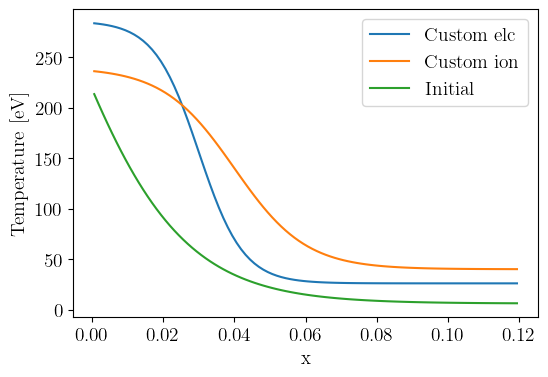

In [ ]:
def temp_initial_profile(x):
    return 6.*ion.T0*(0.5*(1.+np.tanh(3.*(-.1-10.*x)))+0.01)

# custom temperature profile for electrons
T0 = 200*simulation.phys_param.eV
x0 = -0.03 # position of the transition region
c0 = 1.3 # multiplicative factor
c1 = 0.5 # control the temperature at the core
c2 = 8.0 # control the width of the transition region
c3 = 0.1 # control the temperature at the SOL
def temperature_custom_profile_elc(x,T0=T0,x0=x0,c0=c0, c1=c1,c2=c2,c3=c3):
    return c0*T0*(c1*(1.+np.tanh(c2*(-10*(x+x0))))+c3)

# custom temperature profile for ions
T0 = 200*simulation.phys_param.eV
x0 = -0.04
c0 = 1.0
c1 = 0.5
c2 = 5.0
c3 = 0.2
def temperature_custom_profile_ion(x,T0=T0,x0=x0,c0=c0, c1=c1,c2=c2,c3=c3):
    return c0*T0*(c1*(1.+np.tanh(c2*(-10*(x+x0))))+c3)
# plot temperature profile
x = simulation.geom_param.grids[0]
plt.plot(x,temperature_custom_profile_elc(x)/simulation.phys_param.eV,label='Custom elc')
plt.plot(x,temperature_custom_profile_ion(x)/simulation.phys_param.eV,label='Custom ion')
plt.plot(x,temp_initial_profile(x)/simulation.phys_param.eV,label='Initial')
plt.xlabel('x')
plt.ylabel('Temperature [eV]')
plt.legend()
plt.show()

In [ ]:
# Compute the banana width in function of the radial position
x = simulation.geom_param.grids[0]
Rx = simulation.geom_param.R_x(x)
RmLCFS = Rx - simulation.geom_param.R_LCFSmid

temperature = temp_initial_profile(x)
qfactor = qprofile(Rx)

epsilon = simulation.geom_param.get_epsilon()
bw = pygkyl.phys_tools.banana_width(ion.q, ion.m, temperature, Bfield, qfactor, epsilon)

bw100eV = pygkyl.phys_tools.banana_width(ion.q, ion.m, 100*simulation.phys_param.eV, Bfield, qfactor, epsilon)
bw200eV = pygkyl.phys_tools.banana_width(ion.q, ion.m, 200*simulation.phys_param.eV, Bfield, qfactor, epsilon)
bw300eV = pygkyl.phys_tools.banana_width(ion.q, ion.m, 300*simulation.phys_param.eV, Bfield, qfactor, epsilon)

# plot banana width
fig, ax1 = plt.subplots()
#ax1.plot(RmLCFS, bw, label='Banana width initial condition')
ax1.plot(RmLCFS, bw100eV, label='Banana width at 100 eV')
ax1.plot(RmLCFS, bw200eV, label='Banana width at 200 eV')
ax1.plot(RmLCFS, bw300eV, label='Banana width at 300 eV')
ax1.plot(RmLCFS, np.ones_like(RmLCFS)*sigma_srcOMP, '--k', label='sigma source')
ax1.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax1.set_ylabel('Banana width [m]')
plt.legend()
plt.show()

# plot density source and mark the banana width at that temperature
bwsrc = pygkyl.phys_tools.banana_width(ion.q, ion.m, 200*simulation.phys_param.eV, Bfield[0], qfactor[0], epsilon)
fig, ax = plt.subplots()
from pygkyl import Frame
src_density = Frame(simulation,'ne_src',tf=0,load=True)
src_density.slice_1D('x',[0.0,0.0])
src_density = np.squeeze(src_density.values)
ax.plot(RmLCFS, src_density, label='Density source profile')
ax.axvline(x=bwsrc - simulation.geom_param.x_LCFS, color='k', linestyle='--', label='Banana width at source temperature')
ax.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax.set_ylabel('Density source profile')
plt.legend()
plt.show()

# plot qfactor
fig, ax1 = plt.subplots()
color = 'tab:red'
ax1.set_ylabel('safety factor', color=color)
ax1.plot(RmLCFS, qfactor, color=color)
ax1.tick_params(axis='y', labelcolor=color)
# plot banana width
ax2 = ax1.twinx()
color = 'tab:blue'
ax2.set_ylabel('Banana width [m]', color=color)
ax1.set_xlabel(r'$R-R_{LCFS}$ [m]')
ax2.plot(RmLCFS, bw, color=color)
ax2.tick_params(axis='y', labelcolor=color)

NameError: name 'Bfield' is not defined